LOAD DATA DAN AUGMENTASI 

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Ukuran gambar dan batch
img_size = 224
batch_size = 32

# Transformasi untuk training (augmentasi + normalisasi)
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalisasi ke -1 hingga 1 jika RGB jadi [0.5, 0.5, 0.5]
])

# Transformasi untuk testing (hanya resize dan normalisasi)
test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load dataset menggunakan ImageFolder
train_dataset = datasets.ImageFolder(root='dataset_split/train', transform=train_transforms)
test_dataset = datasets.ImageFolder(root='dataset_split/test', transform=test_transforms)

# DataLoader untuk batching dan shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Cek label kelas (mapping folder ke label)
print("Label mapping:", train_dataset.class_to_idx)


Label mapping: {'BacterialSpot': 0, 'Healthy': 1}


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # input RGB (3 channel)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 32 x 112 x 112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 64 x 56 x 56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 128 x 28 x 28

            nn.Dropout(0.3)  # untuk regularisasi
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # ubah ke 1D vektor
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),       # output 1 neuron untuk klasifikasi biner
            nn.Sigmoid()             # agar output di antara 0 dan 1
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNClassifier().to(device)

print(model)


CNNClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [6]:
import torch.optim as optim

# Loss dan optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10  # bisa ditambah
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # reshape jadi (batch, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))

    # Validasi
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    test_losses.append(val_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_losses[-1]:.4f} Acc: {train_acc:.2f}% | "
          f"Val Loss: {test_losses[-1]:.4f} Acc: {val_acc:.2f}%")


Epoch [1/10] Train Loss: 0.1363 Acc: 95.33% | Val Loss: 0.1708 Acc: 97.10%
Epoch [2/10] Train Loss: 0.1094 Acc: 96.85% | Val Loss: 0.1614 Acc: 99.00%
Epoch [3/10] Train Loss: 0.1057 Acc: 96.93% | Val Loss: 0.1651 Acc: 99.00%
Epoch [4/10] Train Loss: 0.0634 Acc: 98.23% | Val Loss: 0.1611 Acc: 99.11%
Epoch [5/10] Train Loss: 0.0561 Acc: 98.53% | Val Loss: 0.1462 Acc: 99.11%
Epoch [6/10] Train Loss: 0.0547 Acc: 98.95% | Val Loss: 0.1243 Acc: 99.33%
Epoch [7/10] Train Loss: 0.0612 Acc: 98.91% | Val Loss: 0.1198 Acc: 99.55%
Epoch [8/10] Train Loss: 0.0608 Acc: 98.70% | Val Loss: 0.1773 Acc: 97.54%
Epoch [9/10] Train Loss: 0.0437 Acc: 98.74% | Val Loss: 0.1259 Acc: 99.55%
Epoch [10/10] Train Loss: 0.0318 Acc: 99.20% | Val Loss: 0.1554 Acc: 99.11%


In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Set model ke eval mode
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        outputs = model(images)
        preds = (outputs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [8]:
# Convert ke array 1D
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)

# Classification Report
target_names = ['Healthy', 'BacterialSpot']
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

Confusion Matrix:
[[355   6]
 [  2 533]]

Classification Report:
               precision    recall  f1-score   support

      Healthy       0.99      0.98      0.99       361
BacterialSpot       0.99      1.00      0.99       535

     accuracy                           0.99       896
    macro avg       0.99      0.99      0.99       896
 weighted avg       0.99      0.99      0.99       896



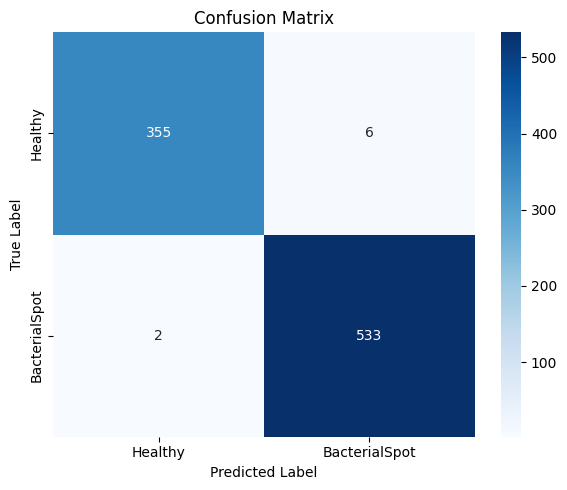

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix (pastikan all_labels dan all_preds sudah terisi sebelumnya)
cm = confusion_matrix(all_labels, all_preds)

# Label kelas
class_names = ['Healthy', 'BacterialSpot']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7254902].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8745098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.78039217].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to 

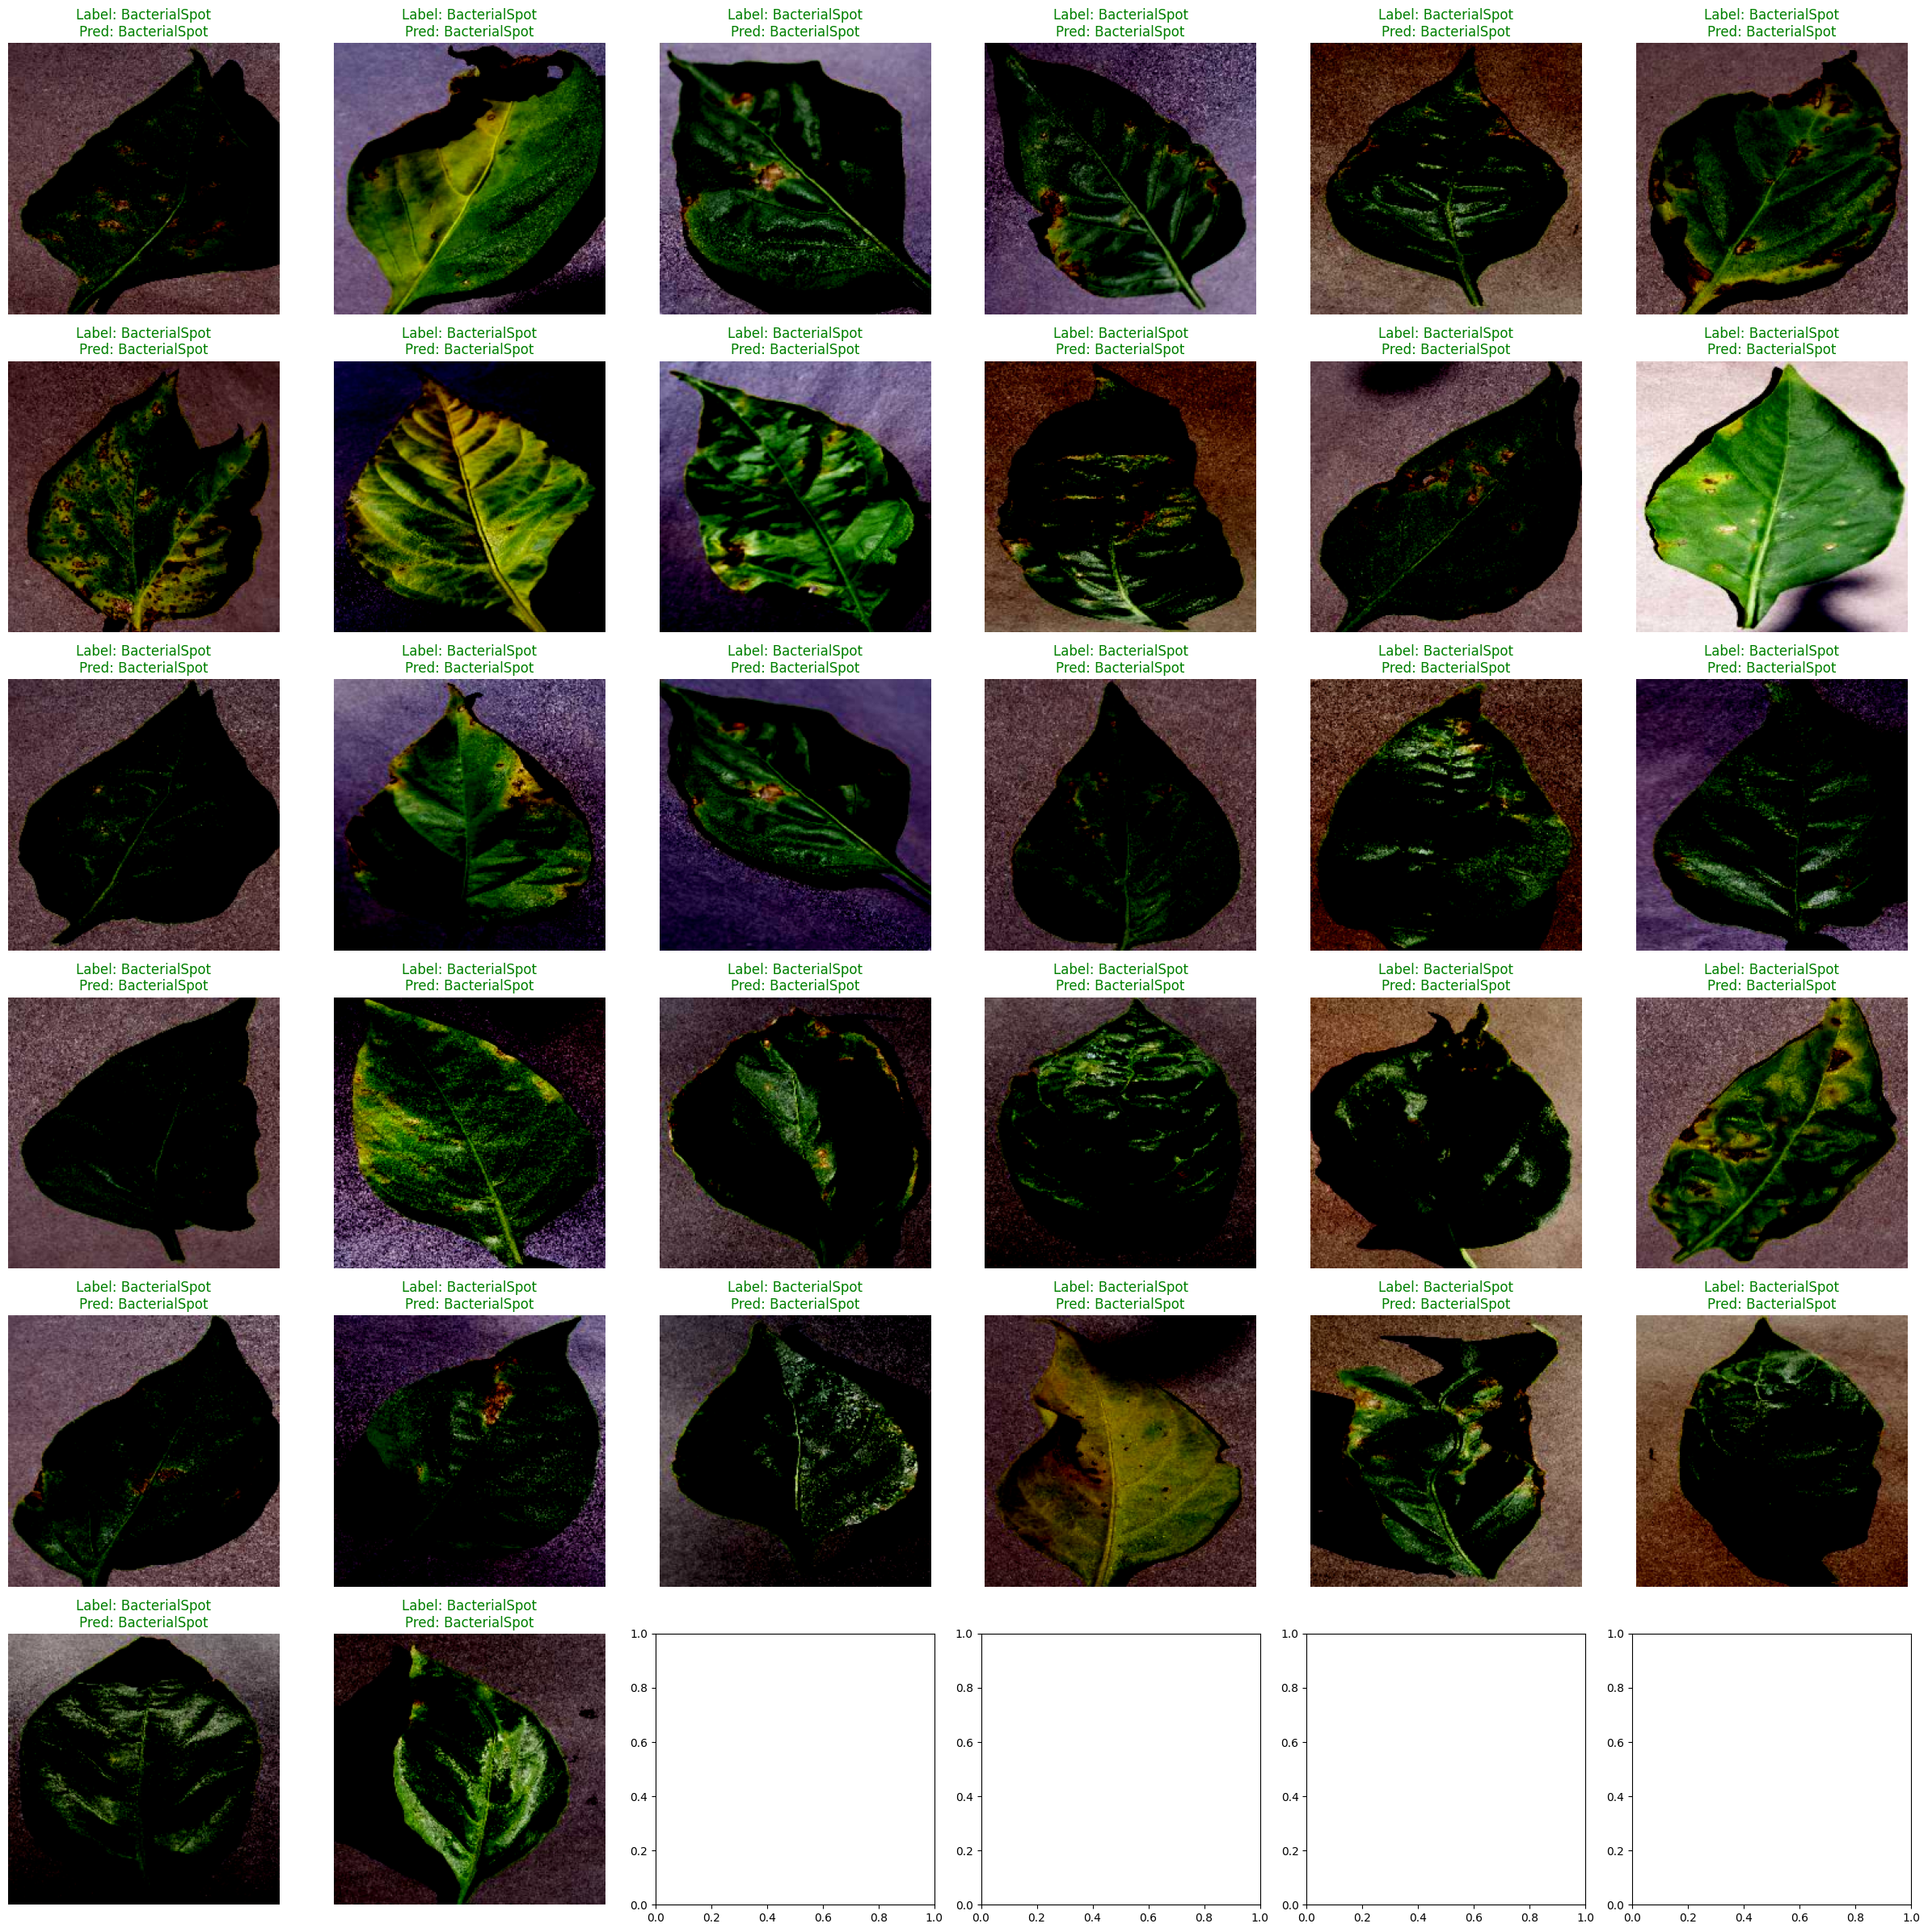

Jumlah prediksi benar: 32
Jumlah prediksi salah: 0
Rasio akurasi pada batch ini: 1.0000


In [41]:
# Buat mapping label ke kategori
label2cat = {i: c for i, c in enumerate(test_loader.dataset.classes)}  # jika val_loader adalah Subset

correct = 0
incorrect = 0

model.eval()

for features, targets in test_loader:
    features, targets = features.to(device), targets.to(device)

    with torch.no_grad():
        outputs = model(features)
        preds = outputs.argmax(dim=1)

    num_samples = min(36, features.size(0))
    indices = torch.randperm(features.size(0))[:num_samples]

    fig, axes = plt.subplots(6, 6, figsize=(24, 24))

    for img, label, pred, ax in zip(features[indices], targets[indices], preds[indices], axes.flatten()):
        img_np = img.cpu().permute(1, 2, 0).numpy()
        if img_np.shape[2] == 1:
            img_np = img_np.squeeze(2)
            ax.imshow(img_np, cmap='gray')
        else:
            ax.imshow(img_np)

        warna_font = 'g' if label == pred else 'r'
        label_name = label2cat[label.item()]
        pred_name = label2cat[pred.item()]
        ax.set_title(f"Label: {label_name}\nPred: {pred_name}", color=warna_font)
        ax.axis('off')

        if label == pred:
            correct += 1
        else:
            incorrect += 0

    plt.tight_layout()
    plt.show()

    break  # hanya 1 batch untuk visualisasi

print(f"Jumlah prediksi benar: {correct}")
print(f"Jumlah prediksi salah: {incorrect}")
print(f"Rasio akurasi pada batch ini: {correct / (correct + incorrect):.4f}")

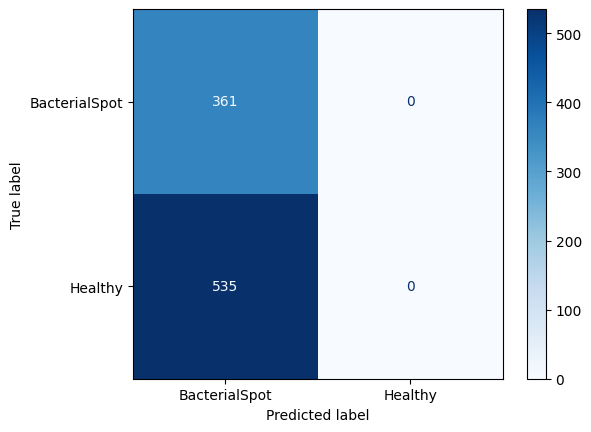

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for features, targets in test_loader:
        features, targets = features.to(device), targets.to(device)
        outputs = model(features)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=test_loader.dataset.classes)
disp.plot(cmap='Blues')
plt.show()

In [43]:
from collections import Counter

targets = [label for _, label in test_loader.dataset]
print(Counter(targets))

Counter({1: 535, 0: 361})


In [ ]:
#Cek akurasi seluruh val/test set
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for features, targets in test_loader:
        features, targets = features.to(device), targets.to(device)
        outputs = model(features)
        preds = outputs.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

print(f"Akurasi seluruh val/test set: {correct / total:.4f}")

Akurasi seluruh val/test set: 0.4029


In [14]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Label
class_names = ['Healthy', 'BacterialSpot']

# Transformasi seperti saat pelatihan
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def predict_image(image_path, model):
    # Load gambar
    image = Image.open(image_path).convert('RGB')
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Prediksi
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        pred = (output > 0.5).float().item()

    # Tampilkan hasil
    label = class_names[int(pred)]

    # Visualisasi gambar
    plt.imshow(image)
    plt.title(f'Prediction: {label}')
    plt.axis('off')
    plt.show()
    
    return label

In [20]:
torch.save(model.state_dict(), 'model_daun_cnn.pth')

In [35]:
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # input RGB (3 channel)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 32 x 112 x 112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 64 x 56 x 56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 128 x 28 x 28

            nn.Dropout(0.3)  # untuk regularisasi
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # ubah ke 1D vektor
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1),       # output 1 neuron untuk klasifikasi biner
            nn.Sigmoid()             # agar output di antara 0 dan 1
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


# Definisikan ulang model dulu (harus sama dengan arsitektur aslinya)
model = CNNClassifier().to(device)
model.load_state_dict(torch.load('model_daun_cnn.pth'))
model.eval()

CNNClassifier(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)